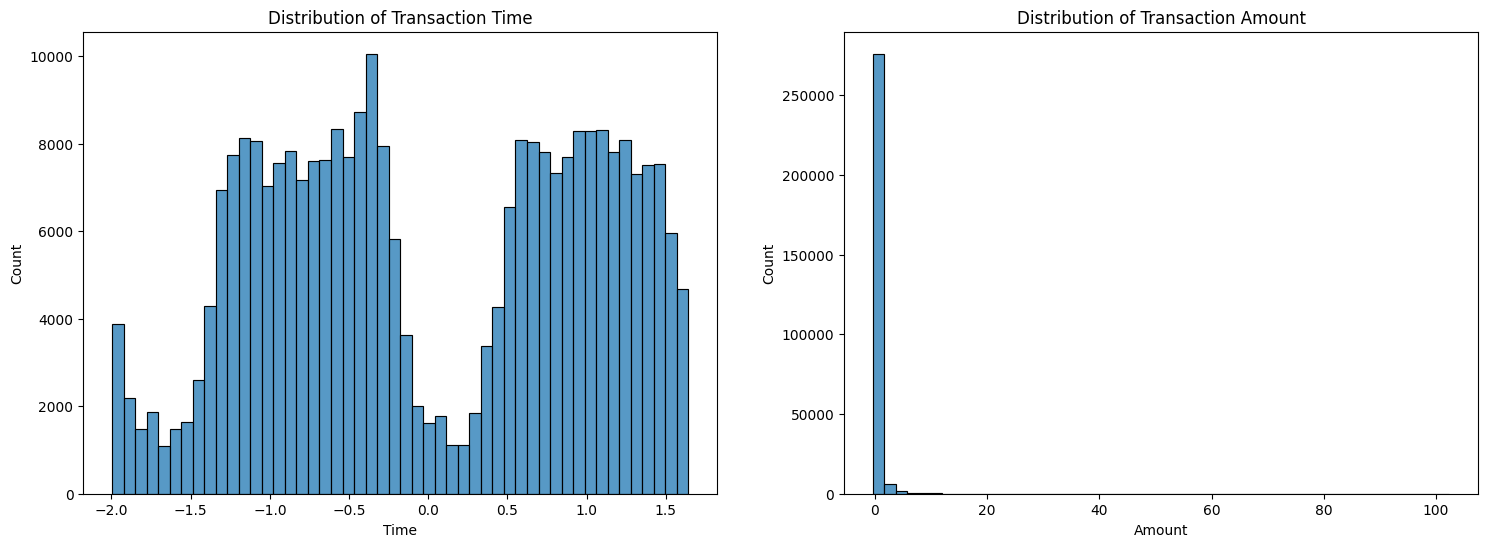

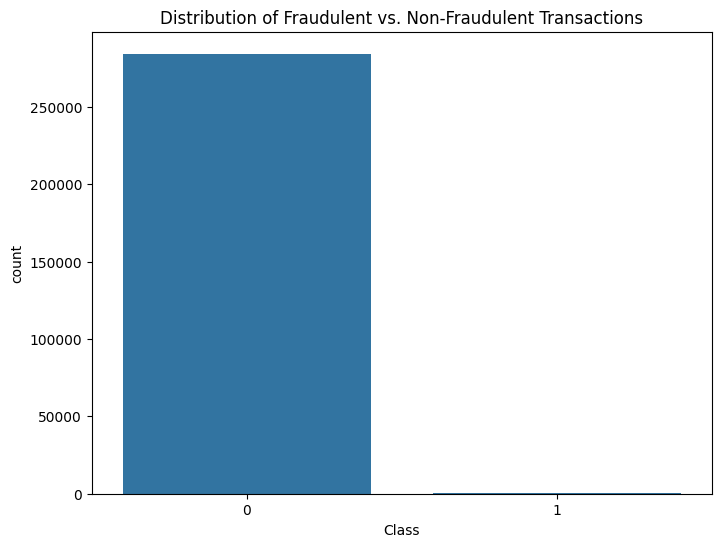

Evaluating Logistic Regression...
AUPRC: 0.9994

Evaluating Random Forest...
AUPRC: 1.0000

Evaluating Gradient Boosting...


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('creditcard.csv')

# Check for NaN values in 'y' (Class)
if data['Class'].isnull().any():
    print("Warning: NaN values found in 'Class'. Handling missing values...")
    data.dropna(subset=['Class'], inplace=True)

# Data Preprocessing
# Normalize and standardize 'Time' and 'Amount'
scaler = StandardScaler()
data['Time'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

# Ensure PCA-transformed features are appropriately scaled (assuming V1 to V28 are PCA components)
pca_features = data.columns[1:29]
data[pca_features] = scaler.fit_transform(data[pca_features])

# Exploratory Data Analysis (EDA)
# Analyze transaction patterns
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(data['Time'], bins=50, ax=axs[0])
axs[0].set_title('Distribution of Transaction Time')
sns.histplot(data['Amount'], bins=50, ax=axs[1])
axs[1].set_title('Distribution of Transaction Amount')
plt.show()

# Visualize the distribution of fraudulent vs. non-fraudulent transactions
fraud = data[data['Class'] == 1]
non_fraud = data[data['Class'] == 0]

plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=data)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.show()

# Feature Engineering
# Create new features: Log of 'Amount' and 'Hour' from 'Time'
data['Log_Amount'] = np.log1p(data['Amount'])
data['Hour'] = (data['Time'] / 3600) % 24

# Create interaction features between PCA components
interaction_features = {}
for i in range(1, 29):
    for j in range(i + 1, 29):
        interaction_features[f'V{i}_x_V{j}'] = data[f'V{i}'] * data[f'V{j}']

# Convert interaction features to DataFrame and concatenate with original data
interaction_df = pd.DataFrame(interaction_features)
data = pd.concat([data, interaction_df], axis=1)

# Model Development
# Separate features and target variable
X = data.drop('Class', axis=1)
y = data['Class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42)
}

# Define evaluation metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auprc = auc(recall, precision)
    
    return {
        'precision': precision,
        'recall': recall,
        'auprc': auprc,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc_score': roc_auc_score(y_test, y_pred_proba)
    }

# Perform cross-validation and evaluate models
results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    cv_results = cross_val_predict(model, X_train_resampled, y_train_resampled, cv=skf, method='predict_proba')
    
    # Calculate AUPRC
    precision, recall, _ = precision_recall_curve(y_train_resampled, cv_results[:, 1])
    auprc = auc(recall, precision)
    
    # Store results
    results[model_name] = {
        'auprc': auprc,
        'cv_results': cv_results
    }

    print(f"AUPRC: {auprc:.4f}\n")

# Print AUPRC results
print("AUPRC Scores:")
for model_name, result in results.items():
    print(f"{model_name}: {result['auprc']:.4f}")

# Optional: Plot Precision-Recall curves
plt.figure(figsize=(8, 6))
for model_name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_train_resampled, result['cv_results'][:, 1])
    plt.plot(recall, precision, label=f"{model_name} (AUPRC = {result['auprc']:.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Print and visualize other metrics like ROC-AUC, Confusion Matrix, etc., for best models
for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"Evaluating {model_name} on Test Set:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba)}\n")
